In [1]:
from models.utils.fastai.basics import *
from models.utils.fastai.vision.all import *
from nbdev.showdoc import *

In [2]:
class GANModule(Module):
    "Wrapper around a `generator` and a `critic` to create a GAN."
    def __init__(self, generator=None, critic=None, gen_mode=False):
        if generator is not None: self.generator=generator
        if critic    is not None: self.critic   =critic
        store_attr('gen_mode')

    def forward(self, *args):
        return self.generator(*args) if self.gen_mode else self.critic(*args)

    def switch(self, gen_mode=None):
        "Put the module in generator mode if `gen_mode`, in critic mode otherwise."
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode

In [3]:
show_doc(GANModule.switch)

<h4 id="GANModule.switch" class="doc_header"><code>GANModule.switch</code><a href="__main__.py#L11" class="source_link" style="float:right">[source]</a></h4>

> <code>GANModule.switch</code>(**`gen_mode`**=*`None`*)

Put the module in generator mode if `gen_mode`, in critic mode otherwise.

In [4]:
class GANLoss(GANModule):
    "Wrapper around `crit_loss_func` and `gen_loss_func`"
    def __init__(self, gen_loss_func, crit_loss_func, gan_model):
        super().__init__()
        store_attr('gen_loss_func,crit_loss_func,gan_model')

    def generator(self, input, output, target):
        "Evaluate the `output` with the critic then uses `self.gen_loss_func`"
        fake_pred = self.gan_model.critic(output)
        self.gen_loss = self.gen_loss_func(fake_pred, output, target)
        return self.gen_loss

    def critic(self, input, real_pred, target):
        "Create some `fake_pred` with the generator from `input` and compare them to `real_pred` in `self.crit_loss_func`."
        #print(len(real_pred))
        #print(target.shape)
        self.gan_model.generator.paramsToUpdate(False)
        fake = self.gan_model.generator(input)
        fake_pred = self.gan_model.critic(fake)
        self.crit_loss = (self.crit_loss_func(real_pred, target) + self.crit_loss_func(fake_pred, target)) / 2
        return self.crit_loss

In [5]:
#export
class AdaptiveLoss(Module):
    "Expand the `target` to match the `output` size before applying `crit`."
    def __init__(self, crit): self.crit = crit
    def forward(self, output, target):
        return self.crit(output, target[:,None].expand_as(output).float())

In [6]:
#export
def accuracy_thresh_expand(y_pred, y_true, thresh=0.5, sigmoid=True):
    "Compute accuracy after expanding `y_true` to the size of `y_pred`."
    if sigmoid: y_pred = y_pred.sigmoid()
    return ((y_pred>thresh).byte()==y_true[:,None].expand_as(y_pred).byte()).float().mean()

In [7]:
#def set_freeze_model(m, rg):
#    for p in m.parameters(): p.requires_grad_(rg)
        
def set_freeze_model(m, rg):
    m.paramsToUpdate(rg)

In [8]:
#export
class GANTrainer(Callback):
    "Handles GAN Training."
    run_after = TrainEvalCallback
    def __init__(self, switch_eval=False, clip=None, beta=0.98, gen_first=False, show_img=True):
        store_attr('switch_eval,clip,gen_first,show_img')
        self.gen_loss,self.crit_loss = AvgSmoothLoss(beta=beta),AvgSmoothLoss(beta=beta)

    def _set_trainable(self):
        train_model = self.generator if     self.gen_mode else self.critic
        loss_model  = self.generator if not self.gen_mode else self.critic
        set_freeze_model(train_model, True)
        set_freeze_model(loss_model, False)
        if self.switch_eval:
            train_model.train()
            loss_model.eval()
            

    def before_fit(self):
        "Initialize smootheners."
        self.generator,self.critic = self.model.generator,self.model.critic
        self.gen_mode = self.gen_first
        self.switch(self.gen_mode)
        self.crit_losses,self.gen_losses = [],[]
        self.gen_loss.reset() ; self.crit_loss.reset()
        #self.recorder.no_val=True
        #self.recorder.add_metric_names(['gen_loss', 'disc_loss'])
        #self.imgs,self.titles = [],[]

    def before_validate(self):
        "Switch in generator mode for showing results."
        self.switch(gen_mode=True)

    def before_batch(self):
        "Clamp the weights with `self.clip` if it's not None, set the correct input/target."
        if self.training and self.clip is not None:
            for p in self.critic.parameters(): p.data.clamp_(-self.clip, self.clip)
        if not self.gen_mode:
            (self.learn.xb,self.learn.yb) = (self.xb,self.yb)

    def after_batch(self):
        "Record `last_loss` in the proper list."
        if not self.training: return
        if self.gen_mode:
            self.gen_loss.accumulate(self.learn)
            self.gen_losses.append(self.gen_loss.value)
            self.last_gen = to_detach(self.pred)
        else:
            self.crit_loss.accumulate(self.learn)
            self.crit_losses.append(self.crit_loss.value)

    def before_epoch(self):
        "Put the critic or the generator back to eval if necessary."
        self.switch(self.gen_mode)

    #def after_epoch(self):
    #    "Show a sample image."
    #    if not hasattr(self, 'last_gen') or not self.show_img: return
    #    data = self.learn.data
    #    img = self.last_gen[0]
    #    norm = getattr(data,'norm',False)
    #    if norm and norm.keywords.get('do_y',False): img = data.denorm(img)
    #    img = data.train_ds.y.reconstruct(img)
    #    self.imgs.append(img)
    #    self.titles.append(f'Epoch {epoch}')
    #    pbar.show_imgs(self.imgs, self.titles)
    #    return add_metrics(last_metrics, [getattr(self.smoothenerG,'smooth',None),getattr(self.smoothenerC,'smooth',None)])

    def switch(self, gen_mode=None):
        "Switch the model and loss function, if `gen_mode` is provided, in the desired mode."
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode
        self._set_trainable()
        self.model.switch(gen_mode)
        self.loss_func.switch(gen_mode)

In [9]:
#export
class FixedGANSwitcher(Callback):
    "Switcher to do `n_crit` iterations of the critic then `n_gen` iterations of the generator."
    run_after = GANTrainer
    def __init__(self, n_crit=1, n_gen=1): store_attr('n_crit,n_gen')
    def before_train(self): self.n_c,self.n_g = 0,0

    def after_batch(self):
        "Switch the model if necessary."
        if not self.training: return
        if self.learn.gan_trainer.gen_mode:
            self.n_g += 1
            n_iter,n_in,n_out = self.n_gen,self.n_c,self.n_g
        else:
            self.n_c += 1
            n_iter,n_in,n_out = self.n_crit,self.n_g,self.n_c
        target = n_iter if isinstance(n_iter, int) else n_iter(n_in)
        if target == n_out:
            self.learn.gan_trainer.switch()
            self.n_c,self.n_g = 0,0

In [10]:
#export
class AdaptiveGANSwitcher(Callback):
    "Switcher that goes back to generator/critic when the loss goes below `gen_thresh`/`crit_thresh`."
    run_after = GANTrainer
    def __init__(self, gen_thresh=None, critic_thresh=None):
        store_attr('gen_thresh,critic_thresh')

    def after_batch(self):
        "Switch the model if necessary."
        if not self.training: return
        if self.gan_trainer.gen_mode:
            if self.gen_thresh is None or self.loss < self.gen_thresh: self.gan_trainer.switch()
        else:
            if self.critic_thresh is None or self.loss < self.critic_thresh: self.gan_trainer.switch()

In [11]:
class GANDiscriminativeLR(Callback):
    "`Callback` that handles multiplying the learning rate by `mult_lr` for the critic."
    run_after = GANTrainer
    def __init__(self, mult_lr=5.): self.mult_lr = mult_lr

    def before_batch(self):
        "Multiply the current lr if necessary."
        if not self.learn.gan_trainer.gen_mode and self.training:
            self.learn.opt.set_hyper('lr', self.learn.opt.hypers[0]['lr']*self.mult_lr)

    def after_batch(self):
        "Put the LR back to its value if necessary."
        if not self.learn.gan_trainer.gen_mode: self.learn.opt.set_hyper('lr', self.learn.opt.hypers[0]['lr']/self.mult_lr)

In [12]:
def gan_loss_from_func(loss_gen, loss_crit, weights_gen=None):
    "Define loss functions for a GAN from `loss_gen` and `loss_crit`."
    def _loss_G(fake_pred, output, target, weights_gen=weights_gen):
        ones = fake_pred.new_ones(fake_pred.shape[0])
        weights_gen = ifnone(weights_gen, (1.,1.))
        return weights_gen[0] * loss_crit(fake_pred, ones) + weights_gen[1] * loss_gen(output, target)

    def _loss_C(real_pred, fake_pred):
        ones  = real_pred.new_ones (real_pred.shape[0])
        zeros = fake_pred.new_zeros(fake_pred.shape[0])
        return (loss_crit(real_pred, ones) + loss_crit(fake_pred, zeros)) / 2

    return _loss_G, _loss_C

In [13]:
def _tk_mean(fake_pred, output, target): return fake_pred.mean()
def _tk_diff(real_pred, fake_pred): return real_pred.mean() - fake_pred.mean()

In [14]:
@delegates()
class GANLearner(Learner):
    "A `Learner` suitable for GANs."
    def __init__(self, dls, generator, critic, gen_loss_func, crit_loss_func, switcher=None, gen_first=False,
                 switch_eval=True, show_img=True, clip=None, cbs=None, metrics=None, **kwargs):
        gan = GANModule(generator, critic)
        loss_func = GANLoss(gen_loss_func, crit_loss_func, gan)
        if switcher is None: switcher = FixedGANSwitcher()
        trainer = GANTrainer(clip=clip, switch_eval=switch_eval, gen_first=gen_first, show_img=show_img)
        cbs = L(cbs) + L(trainer, switcher)
        metrics = L(metrics) + L(*LossMetrics('gen_loss,crit_loss'))
        super().__init__(dls, gan, loss_func=loss_func, cbs=cbs, metrics=metrics, **kwargs)

    @classmethod
    def from_learners(cls, gen_learn, crit_learn, switcher=None, weights_gen=None, **kwargs):
        "Create a GAN from `learn_gen` and `learn_crit`."
        losses = gan_loss_from_func(gen_learn.loss_func, crit_learn.loss_func, weights_gen=weights_gen)
        return cls(gen_learn.dls, gen_learn.model, crit_learn.model, *losses, switcher=switcher, **kwargs)

    @classmethod
    def wgan(cls, dls, generator, critic, switcher=None, clip=0.01, switch_eval=False, **kwargs):
        "Create a WGAN from `data`, `generator` and `critic`."
        if switcher is None: switcher = FixedGANSwitcher(n_crit=5, n_gen=1)
        return cls(dls, generator, critic, _tk_mean, _tk_diff, switcher=switcher, clip=clip, switch_eval=switch_eval, **kwargs)

GANLearner.from_learners = delegates(to=GANLearner.__init__)(GANLearner.from_learners)
GANLearner.wgan = delegates(to=GANLearner.__init__)(GANLearner.wgan)

In [16]:
def _accumulate(self, learn):
        bs = find_bs(learn.yb)
        print("bs", bs)
        if self.attr == 'gen_loss':
            self.total += learn.to_detach(getattr(learn.loss_func, self.attr, 0))*bs
        else:
            self.total += learn.to_detach(getattr(learn.loss_func, self.attr, 0))*bs
        self.count += bs
#LossMetric.accumulate = _accumulate

In [41]:
class _Metric():
    "Blueprint for defining a metric"
    def reset(self): pass
    def accumulate(self, learn): pass
    @property
    def value(self): raise NotImplementedError

    @property
    def name(self): return class2attr(self, 'Metric')

    _docs = dict(
        reset="Reset inner state to prepare for new computation",
        name="Name of the `Metric`, camel-cased and with Metric removed",
        accumulate="Use `learn` to update the state with new results",
        value="The value of the metric")
Metric = _Metric

# Cell
def _maybe_reduce(val):
    if num_distrib()>1:
        val = val.clone()
        torch.distributed.all_reduce(val, op=torch.distributed.ReduceOp.SUM)
        val /= num_distrib()
    return val

# Cell
class _AvgMetric(_Metric):
    "Average the values of `func` taking into account potential different batch sizes"
    def __init__(self, func):  self.func = func
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        print("AvgMetric")
        bs = find_bs(learn.yb)
        self.total += learn.to_detach(self.func(*learn.xb, learn.pred, *learn.yb))*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return self.func.func.__name__ if hasattr(self.func, 'func') else  self.func.__name__
AvgMetric = _AvgMetric
# Cell
class _AvgLoss(_Metric):
    "Average the losses taking into account potential different batch sizes"
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        print("AvgLoss")
        bs = find_bs(learn.yb)
        self.total += learn.to_detach(learn.loss.mean())*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return "loss"
AvgLoss = _AvgLoss

# Cell
class _AvgSmoothLoss(_Metric):
    "Smooth average of the losses (exponentially weighted with `beta`)"
    def __init__(self, beta=0.98): self.beta = beta
    def reset(self):               self.count,self.val = 0,tensor(0.)
    def accumulate(self, learn):
        print("AvgSmoothLoss")
        self.count += 1
        self.val = torch.lerp(to_detach(learn.loss.mean(), gather=False), self.val, self.beta)
    @property
    def value(self): return self.val/(1-self.beta**self.count)
AvgSmoothLoss = _AvgSmoothLoss
# Cell
class ValueMetric(_Metric):
    "Use to include a pre-calculated metric value (for instance calculated in a `Callback`) and returned by `func`"
    def __init__(self, func, metric_name=None): store_attr('func, metric_name')

    @property
    def value(self): return self.func()

    @property
    def name(self): return self.metric_name if self.metric_name else self.func.__name__

In [40]:
class _Recorder(Callback):
    "Callback that registers statistics (lr, loss and metrics) during training"
    _stateattrs=('lrs','iters','losses','values')
    remove_on_fetch,order = True,50

    def __init__(self, add_time=True, train_metrics=False, valid_metrics=True, beta=0.98):
        store_attr('add_time,train_metrics,valid_metrics')
        self.loss,self.smooth_loss = _AvgLoss(),_AvgSmoothLoss(beta=beta)

    def before_fit(self):
        "Prepare state for training"
        self.lrs,self.iters,self.losses,self.values = [],[],[],[]
        names = self.metrics.attrgot('name')
        if self.train_metrics and self.valid_metrics:
            names = L('loss') + names
            names = names.map('train_{}') + names.map('valid_{}')
        elif self.valid_metrics: names = L('train_loss', 'valid_loss') + names
        else: names = L('train_loss') + names
        if self.add_time: names.append('time')
        self.metric_names = 'epoch'+names
        self.smooth_loss.reset()

    def after_batch(self):
        "Update all metrics and records lr and smooth loss in training"
        if len(self.yb) == 0: return
        mets = self._train_mets if self.training else self._valid_mets
        for met in mets: met.accumulate(self.learn)
        if not self.training: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.smooth_loss.value)
        self.learn.smooth_loss = self.smooth_loss.value

    def before_epoch(self):
        "Set timer if `self.add_time=True`"
        self.cancel_train,self.cancel_valid = False,False
        if self.add_time: self.start_epoch = time.time()
        self.log = L(getattr(self, 'epoch', 0))

    def before_train   (self): self._train_mets[1:].map(Self.reset())
    def before_validate(self): self._valid_mets.map(Self.reset())
    def after_train   (self): self.log += self._train_mets.map(_maybe_item)
    def after_validate(self): self.log += self._valid_mets.map(_maybe_item)
    def after_cancel_train(self):    self.cancel_train = True
    def after_cancel_validate(self): self.cancel_valid = True

    def after_epoch(self):
        "Store and log the loss/metric values"
        self.learn.final_record = self.log[1:].copy()
        self.values.append(self.learn.final_record)
        if self.add_time: self.log.append(format_time(time.time() - self.start_epoch))
        self.logger(self.log)
        self.iters.append(self.smooth_loss.count)

    @property
    def _train_mets(self):
        if getattr(self, 'cancel_train', False): return L()
        return L(self.smooth_loss) + (self.metrics if self.train_metrics else L())

    @property
    def _valid_mets(self):
        if getattr(self, 'cancel_valid', False): return L()
        return (L(self.loss) + self.metrics if self.valid_metrics else L())

    def plot_loss(self, skip_start=5, with_valid=True):
        plt.plot(list(range(skip_start, len(self.losses))), self.losses[skip_start:], label='train')
        if with_valid:
            idx = (np.array(self.iters)<skip_start).sum()
            plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(1), label='valid')
            plt.legend()
Recorder = _Recorder


# def avgmet_accumulate(self, learn):
#     print("Accumulating")
#     bs = find_bs(learn.yb)
#     self.total += learn.to_detach(self.func(*learn.xb, learn.pred, *learn.yb))*bs
#     self.count += bs

# AvgMetric.accumulate = avgmet_accumulate

In [15]:
def GAN_Accuracy(input, preds, target): 
    
    
    #learner.gan_model.generator.paramsToUpdate(False)
    #fake = learner.gan_model.generator(input)
    #fake_pred = self.gan_model.critic(fake)
    
    if len(preds) == 2:
        fakePreds = learner.gan_trainer.critic(preds[0])
        _, pred = torch.max(fakePreds[0], 1)
        return (pred.cuda() == target[1].cuda()).float().mean()
    else:
        _, pred = torch.max(preds[0], 1)
        return (pred.cuda() == target[1].cuda()).float().mean()
    
def _accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp[0].argmax(dim=axis), targ)
    return (pred == targ).float().mean()

# Cell
def _error_rate(inp, targ, axis=-1):
    "1 - `accuracy`"
    return 1 - accuracy(inp, targ, axis=axis)

# Cell
def _top_k_accuracy(inp, targ, k=5, axis=-1):
    "Computes the Top-k accuracy (`targ` is in the top `k` predictions of `inp`)"
    inp = inp[0].topk(k=k, dim=axis)[1]
    targ = targ.unsqueeze(dim=axis).expand_as(inp)
    return (inp == targ).sum(dim=-1).float().mean()

In [16]:
from models.utils.fastai.metrics import *
from models.utils.fastai.callback.tracker import SaveModelCallback
from models.utils.fastai import torch_core

from models.utils.joiner3 import *
from models.utils.misc import *
from models.unet import UNet
from models.utils.new_losses import *

In [17]:
#Parameters
H = 256
W= 256
bs =5
grid_l = 16
nclass = 10
pf = "3"
epochs = 1

beta = 0.00001 #0.0002
beta_str = '5e-6'
gamma = 0.0005
sigma = 1.0

lr = 3e-4
lr_str = '3e-4'

In [18]:
#path = untar_data(URLs.CIFAR)
path = untar_data(URLs.IMAGENETTE_320)

transform = ([*aug_transforms(),Normalize.from_stats([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=parent_label,
                 item_tfms=Resize(H,W),
                 batch_tfms=transform)

dloader = data.dataloaders(path,bs=bs)

In [19]:
gen = UNet(n_channels=3, n_classes=3, bilinear=False)
crt = ImageNetJoiner(num_encoder_layers = 6, nhead=8, num_classes = nclass, batch_size=bs, hidden_dim=512, image_h=H, image_w=W, grid_l=grid_l)

In [20]:
generator_loss = GeneratorLoss(beta, gamma,sigma)
critic_loss = CriticLoss(beta=beta, sigma=sigma, enc_layer_idx=0, pf=pf)

In [21]:
gan_mod = GANModule(gen, crt)

In [23]:
gan_loss = GANLoss(generator_loss,critic_loss,gan_mod)

In [22]:
learner = GANLearner(dloader,gen,crt,generator_loss,critic_loss,gen_first=True, metrics=[GAN_Accuracy])

/home/atsumilab/Luiz/gan_attention/models/utils/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/atsumilab/Luiz/gan_attention/models/utils/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/atsumilab/Luiz/gan_attention/models/utils/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,GAN_Accuracy,gen_loss,crit_loss,time


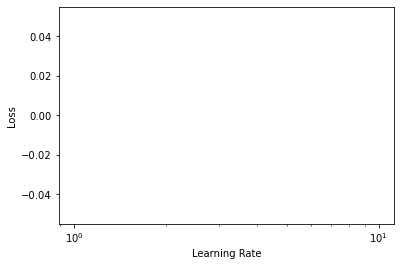

In [23]:
learner.lr_find()

In [24]:
learner.fit_one_cycle(1,0.0002)

epoch,train_loss,valid_loss,GAN_Accuracy,gen_loss,crit_loss,time


epoch,train_loss,valid_loss,GAN_Accuracy,gen_loss,crit_loss,time
0,1.509376,0.884788,0.126587,0.884787,2.543373,05:10
0,1.509376,0.884788,0.126587,0.884787,2.543373,05:10


In [ ]:
class Metric():
    "Blueprint for defining a metric"
    def reset(self): pass
    def accumulate(self, learn): pass
    @property
    def value(self): raise NotImplementedError

    @property
    def name(self): return class2attr(self, 'Metric')

    _docs = dict(
        reset="Reset inner state to prepare for new computation",
        name="Name of the `Metric`, camel-cased and with Metric removed",
        accumulate="Use `learn` to update the state with new results",
        value="The value of the metric")

# Cell
def _maybe_reduce(val):
    if num_distrib()>1:
        val = val.clone()
        torch.distributed.all_reduce(val, op=torch.distributed.ReduceOp.SUM)
        val /= num_distrib()
    return val

# Cell
class _AvgMetric(Metric):
    "Average the values of `func` taking into account potential different batch sizes"
    def __init__(self, func):  self.func = func
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)
        self.total += learn.to_detach(self.func(*learn.xb, learn.pred, *learn.yb))*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return self.func.func.__name__ if hasattr(self.func, 'func') else  self.func.__name__

# Cell
class AvgLoss(Metric):
    "Average the losses taking into account potential different batch sizes"
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)
        self.total += learn.to_detach(learn.loss.mean())*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return "loss"

# Cell
class AvgSmoothLoss(Metric):
    "Smooth average of the losses (exponentially weighted with `beta`)"
    def __init__(self, beta=0.98): self.beta = beta
    def reset(self):               self.count,self.val = 0,tensor(0.)
    def accumulate(self, learn):
        self.count += 1
        self.val = torch.lerp(to_detach(learn.loss.mean(), gather=False), self.val, self.beta)
    @property
    def value(self): return self.val/(1-self.beta**self.count)

# Cell
class ValueMetric(Metric):
    "Use to include a pre-calculated metric value (for instance calculated in a `Callback`) and returned by `func`"
    def __init__(self, func, metric_name=None): store_attr('func, metric_name')

    @property
    def value(self): return self.func()

    @property
    def name(self): return self.metric_name if self.metric_name else self.func.__name__